In [ ]:
# uncomment if you're don't have wget
!pip install wget


  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=418ef4749d8971ca9327ae20d5d67427f309cde59bc64068d4ff228fd50cd723
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import wget
import torch
import os
%matplotlib inline

In [ ]:
#константы
LINK = 'https://api.blockchain.info/charts/market-price?format=csv'
LINK2 = ''
percentage = 100

In [ ]:
#импорт данных
if not os.path.exists('market-price.csv'):
    wget.download(LINK, "market-price.csv")
data = pd.read_csv('market-price.csv')
data = data.rename(columns={data.columns[0]: "Date", data.columns[1]: "Price"})[:int(len(data.values)*percentage/100)]
prices = torch.Tensor(data['Price'].values)

In [ ]:
#рассчет доходностей
data['r'] = data['Price'][1:].reset_index(drop=True)/data['Price'][:-1].reset_index(drop=True) - 1
r = prices[1:]/prices[:-1] - 1

In [ ]:
data

,Date,Price,r
0,2021-04-19 00:00:00,56251.48,-0.009748
1,2021-04-20 00:00:00,55703.14,0.014447
2,2021-04-21 00:00:00,56507.91,-0.047765
3,2021-04-22 00:00:00,53808.80,-0.038601
4,2021-04-23 00:00:00,51731.71,-0.011184
...,...,...,...
360,2022-04-14 00:00:00,41148.06,-0.029361
361,2022-04-15 00:00:00,39939.90,0.015681
362,2022-04-16 00:00:00,40566.20,-0.004374
363,2022-04-17 00:00:00,40388.78,-0.016770


In [ ]:
#рассчет скользящих средник 
short = 5
long = 12
data['SMA'] = data['Price'].rolling(short).mean()
data['LMA'] = data['Price'].rolling(long).mean()

In [ ]:
data

,Date,Price,r,SMA,LMA
0,2021-04-19 00:00:00,56251.48,-0.009748,NaN,NaN
1,2021-04-20 00:00:00,55703.14,0.014447,NaN,NaN
2,2021-04-21 00:00:00,56507.91,-0.047765,NaN,NaN
3,2021-04-22 00:00:00,53808.80,-0.038601,NaN,NaN
4,2021-04-23 00:00:00,51731.71,-0.011184,54800.608,NaN
...,...,...,...,...,...
360,2022-04-14 00:00:00,41148.06,-0.029361,41134.160,43247.878333
361,2022-04-15 00:00:00,39939.90,0.015681,40564.602,42757.423333
362,2022-04-16 00:00:00,40566.20,-0.004374,40248.996,42269.146667
363,2022-04-17 00:00:00,40388.78,-0.016770,40429.028,41750.606667


In [ ]:
def moving_average(X: torch.Tensor, width: int) -> torch.Tensor:
    ret:torch.Tensor = torch.cumsum(X, dim=0)
    ret[width:] = ret[width:] - ret[:-width]
    return ret[width - 1:] / width

r = prices[1:]/prices[:-1] - 1
short_moving = moving_average(prices, short)[long-short:-1]
long_moving = moving_average(prices, long)[:-1]
r = r[long-1:]
short_moving.size(0), long_moving.size(0), r.size(0)

(353, 353, 353)

In [ ]:
#Избавляемся от ненужных строк
data = data.drop(len(data)-1)
data = data.drop(data.index[0:long-1])

In [ ]:
#рассчитываем доходность стратегии
data['strategy'] = data['r']*(data['SMA']>data['LMA']) - data['r']*(data['SMA']<data['LMA'])


In [ ]:
strat = r * (short_moving > long_moving) - r * (short_moving < long_moving)

In [ ]:
data

,Date,Price,r,SMA,LMA,strategy
11,2021-04-30 00:00:00,53584.15,0.078614,53334.386,53494.885833,-0.078614
12,2021-05-01 00:00:00,57796.62,0.001053,55078.594,53623.647500,0.001053
13,2021-05-02 00:00:00,57857.50,-0.021554,55838.766,53803.177500,-0.021554
14,2021-05-03 00:00:00,56610.46,0.010649,56146.566,53811.723333,0.010649
15,2021-05-04 00:00:00,57213.33,-0.069418,56612.412,54095.434167,-0.069418
...,...,...,...,...,...,...
359,2022-04-13 00:00:00,40102.20,0.026080,41360.336,43675.753333,-0.026080
360,2022-04-14 00:00:00,41148.06,-0.029361,41134.160,43247.878333,0.029361
361,2022-04-15 00:00:00,39939.90,0.015681,40564.602,42757.423333,-0.015681
362,2022-04-16 00:00:00,40566.20,-0.004374,40248.996,42269.146667,0.004374


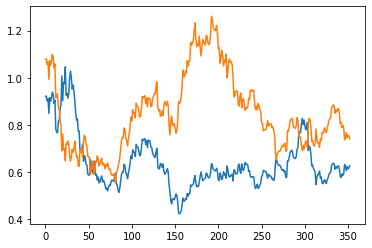

In [ ]:
plt.plot(torch.cumprod(1 + strat, dim=0))
plt.plot(torch.cumprod(1 + r, dim=0))
plt.show()

Годовая доходность стратегии скользящих средних -28.69%
Годовая доходность стратегии buy and hold -19.53%


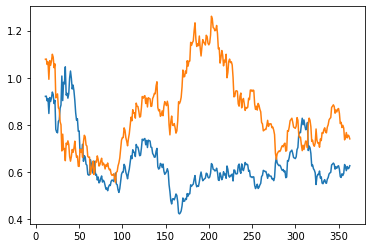

In [ ]:
#визуализируем результаты
plt.plot(np.cumprod(1+data['strategy']))
plt.plot(np.cumprod(1+data['r']))
r_strat = np.prod(1+data['strategy'])**(256/len(data['strategy'])) - 1
r_bnh = np.prod(1+data['r'])**(256/len(data['r'])) - 1
print('Годовая доходность стратегии скользящих средних '+str(round(r_strat*100,2))+'%')
print('Годовая доходность стратегии buy and hold '+str(round(r_bnh*100,2))+'%')

In [ ]:
#функции для подсчета доходностей
def profitability_bnh(prices: torch.Tensor):
    """
      Доходность стратегии Buy and hold за весь период
    """
    r = prices[1:]/prices[:-1] - 1
    return torch.prod(1 + r, dim=0) - 1

def profability_mooving_average(prices: torch.Tensor, short: int, long: int):
    """
      Доходность скользящих средних за весь период
    """
    r = prices[1:]/prices[:-1] - 1
    short_moving = moving_average(prices, short)[long-short:-1]
    long_moving = moving_average(prices, long)[:-1]
    r = r[long-1:]
    strat = r * (short_moving > long_moving) - r * (short_moving < long_moving)
    return torch.prod(1 + strat, dim=0) - 1

In [ ]:
profitability_bnh(prices), profability_mooving_average(prices, 3, 20)

(tensor(-0.2940), tensor(-0.0558))

In [ ]:
def sgd_step(x_0:int, y_0:int):
    a = profability_mooving_average(prices, x_0,y_0)
    b = profability_mooving_average(prices, x_0 + 1,y_0)
    c = profability_mooving_average(prices, x_0 - 1,y_0)
    d = profability_mooving_average(prices, x_0,y_0 + 1)
    e = profability_mooving_average(prices, x_0,y_0 - 1)
    if a == max(a,b,c,d,e):
        return x_0,y_0
    elif b == max(a,b,c,d,e):
        return (x_0 + 1,y_0)
    elif c == max(a,b,c,d,e):
        return (x_0 - 1,y_0)
    elif d == max(a,b,c,d,e):
        return (x_0, y_0 + 1)
    else:
        return (x_0, y_0 - 1)

def sgd(x_0:int, y_0:int):
    (x,y) = sgd_step(x_0,y_0)
    while (x, y) != (x_0, y_0):
        x_0, y_0 = x, y
        (x, y) = sgd_step(x_0, y_0)
    return x_0, y_0
    
    

In [ ]:
x, y = sgd(3,22)
print(x, y)
print(profability_mooving_average(prices, x, y))

4 22
tensor(0.1364)


In [ ]:
import random

In [ ]:
def monte(n:int):
  l=[]
  x=np.zeros(n, dtype=int)
  y=np.zeros(n, dtype=int)
  x_0=np.zeros(n, dtype=int)
  y_0=np.zeros(n, dtype=int)
  for i in range(n):
    x[i] = random.randint(2,20)
    y[i] = random.randint(x[i] + 1,50)
    #print(x[i], y[i])
    x_0[i],y_0[i] = sgd(x[i],y[i])
    #print(int(x_0[i]), int(y_0[i]))
    l.append(float(profability_mooving_average(prices, int(x_0[i]), int(y_0[i]))))
  maximize = max(l)
  idx = l.index(maximize)

  #print(l)
  return maximize, x_0[idx], y_0[idx]



In [ ]:
print(monte(20))

(0.551207423210144, 3, 37)
